In [1]:
import numpy as np, matplotlib.pyplot as plt, joblib, h5py, os, cv2, time, sys, imageio, tqdm
from glob import glob
from os.path import join, exists
from scipy.ndimage import gaussian_filter
from scipy.ndimage.morphology import *
from top_bottom_moseq.io import *

In [2]:
def vec_to_angle(v, degrees=False):
    a = np.arctan(v[:,1]/v[:,0]) + np.pi*(v[:,0]>0)
    if degrees: a = a / np.pi * 180
    return a

In [9]:
name = 'top_bottom_dataset_3_kappa5e5'
base_dir = '/n/groups/datta/Jonah/Thermistor_only_recordings/top_bottom_dataset3'
relative_output_dir = 'crowd_plots'
full_out_path = join(base_dir, relative_output_dir, name)
overwrite = True
if not exists(full_out_path):
    os.makedirs(full_out_path)    
full_out_path

'/n/groups/datta/Jonah/Thermistor_only_recordings/top_bottom_dataset3/crowd_plots/top_bottom_dataset_3_kappa5e5'

In [10]:
# make a list of sessions to include
prefixes = [f.split('.')[0] for f in glob('/n/groups/datta/Jonah/Thermistor_only_recordings/*/202210*/*.stateseq.npy')]

stateseqs = [np.load(prefix+'.stateseq.npy') for prefix in prefixes]
crop_origins = [np.load(prefix+'.crop_centers.npy') for prefix in prefixes]

In [11]:
XY_OFFSET = 320 - np.mean(np.vstack(crop_origins),axis=0)
IMSIZE = (640,640)
CROP_MARGIN = 64
PREBUFFER = 50
POSTBUFFER = 80
MAX_DUR = 100
NUM_MICE = 15
vmins = [.15,.05,.15,.08]
vmaxs = [0.6, 0.4, 0.6, 0.25]
total_syllables = 100
suffixes = ['top.ir','top.depth','bottom.ir','bottom.depth']
colormap = plt.cm.viridis


In [ ]:

labels = np.hstack(stateseqs)
data_ix = np.hstack([np.ones(len(l))*i for i,l in enumerate(stateseqs)])
from_start = np.hstack([np.arange(len(l)) for l in stateseqs])
from_end = np.hstack([np.arange(len(l))[::-1] for l in stateseqs])
usage_rank = np.argsort(np.argsort(np.bincount(np.hstack(labels), minlength=100))[::-1])

for ii in tqdm.trange(total_syllables):
    
    vid_name = 'crowd_plots_'+repr(usage_rank[ii])+'_'+repr(ii)+'.mp4'
    vid_path = join(full_out_path, vid_name)
    if exists(vid_path) and not overwrite:
        print(f'{vid_name} exists, continuing...')
        continue
    syllable_starts = np.nonzero(np.all([labels[1:]==ii,labels[:-1]!=ii],axis=0))[0]+1
    if len(syllable_starts) < NUM_MICE: continue
    if len(syllable_starts) > 500: syllable_starts = np.array(sorted(set(syllable_starts[np.random.randint(0,len(syllable_starts),500)])))

    syllable_durs = np.minimum(np.array([np.min([MAX_DUR]+list(np.nonzero(labels[i:i+MAX_DUR] != ii)[0])) for i in syllable_starts]), MAX_DUR)
    syll_ff = np.all([from_start[syllable_starts]>PREBUFFER, 
                      from_end[syllable_starts] > POSTBUFFER],axis=0)
    syllable_starts = syllable_starts[syll_ff]
    syllable_durs = syllable_durs[syll_ff]

    rand_ix = np.random.permutation(len(syllable_starts))[:NUM_MICE] 
    canvas = np.zeros((len(suffixes),POSTBUFFER+PREBUFFER,IMSIZE[1],IMSIZE[0],3))

    for start,dur in zip(syllable_starts[rand_ix],syllable_durs[rand_ix]):
        print(start,dur)
        ix = data_ix[start].astype(int)
        start_frame = from_start[start]

        x,y = (crop_origins[ix][start_frame-PREBUFFER:start_frame+POSTBUFFER]+XY_OFFSET).T
        if x.min()<96 or y.min()<96 or x.max()>IMSIZE[0]-96 or y.max()>IMSIZE[0]-96: 
            print(x.min(), x.max(), y.min(), y.max())
            continue
            
        for suff_ix,(suffix,vmin,vmax) in enumerate(zip(suffixes,vmins,vmaxs)):
            all_data = read_frames(prefixes[ix]+'.'+suffix+'_inpainted.avi', range(start_frame-PREBUFFER,start_frame+POSTBUFFER), frame_size=(192,192), pixel_format='gray8').astype(float)/255
            for i in range(all_data.shape[0]):
                data = np.array(all_data[i])
                mask = (data > 0.02).astype(float) 
                data = (colormap(np.clip((data-vmin)/(vmax-vmin),0,1))*255*mask[:,:,None]).astype(np.uint8)[:,:,:3]                
                if i >= PREBUFFER and i<= PREBUFFER+dur: data = cv2.circle(data.copy(), (96,96), 10, (255, 0, 0), -1)
                xx,yy = int(x[i]),int(y[i])
                canvas[suff_ix,i,yy-96:yy+96,xx-96:xx+96,:] = data*mask[:,:,None]+(1-mask[:,:,None])*canvas[suff_ix,i,yy-96:yy+96,xx-96:xx+96,:]
                
    canvas = canvas[:,:,CROP_MARGIN:-CROP_MARGIN,CROP_MARGIN:-CROP_MARGIN,:]
    full_canvas = np.concatenate([canvas[suff_ix] for suff_ix in range(len(suffixes))],axis=2)
    
    writer = imageio.get_writer(vid_path, pixelformat='yuv420p', quality=7, fps=30)
    for i in range(full_canvas.shape[0]):
        writer.append_data(full_canvas[i,:,:,:].astype(np.uint8))
    writer.close()



    

  0%|                                                                                       | 0/100 [00:00<?, ?it/s]

458694 3
952461 6
478901 16
967824 12
53117 15
609065 24
617756 4
399925 12
965561 14
131270 9
868465 6
51064 3
1565636 4
1114819 7
1079202 5


  2%|█▌                                                                             | 2/100 [01:00<49:20, 30.21s/it]

86507 33
1320855 11
46461 9
801132 15
188680 9
151160 11
868006 14
523109 4
1615390 10
380954 6
55398 31
357835 24
644405 6
57571 19
1561174 5


  3%|██▎                                                                          | 3/100 [02:03<1:11:15, 44.08s/it]

533847 2
1254107 7
504920 32
901245 10
1595868 13
1603804 25
1377837 9
1327080 13
985234 3
1605762 7
430406 4
189141 7
1418294 8
1246481 12


In [ ]:
# If you queue this cell to run after the above cell, 
# the notebook will get saved when it's done.
# This helps with being able to close the notebook (via tmux)
# and let it run in the bkgd, and then coming back to find its progress.

from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

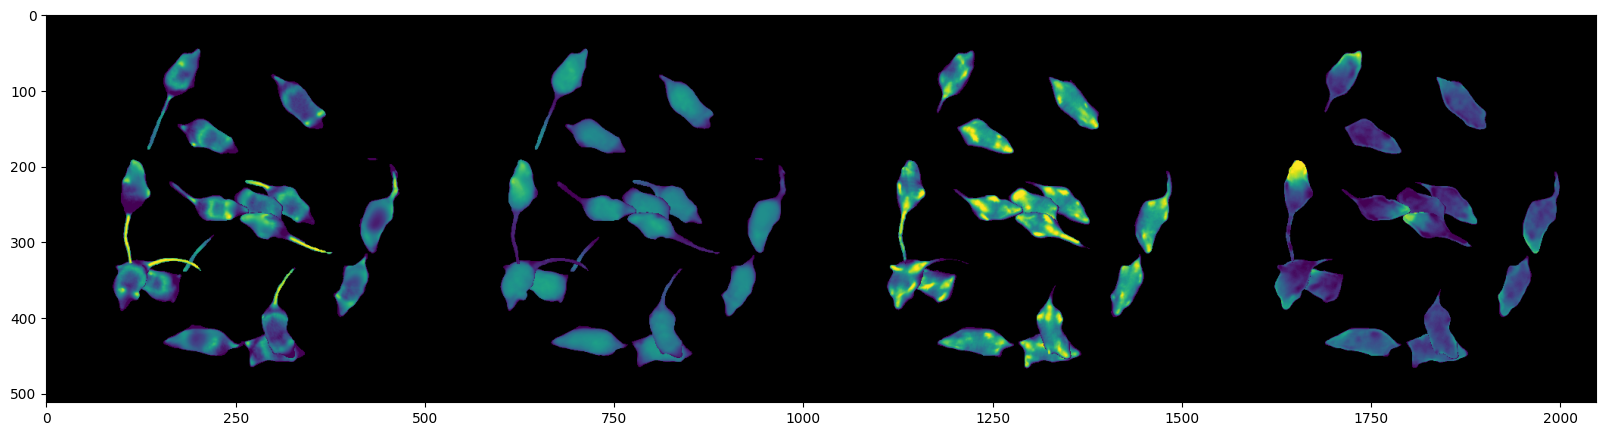

In [9]:
plt.imshow(full_canvas[0].astype(np.uint8))
plt.gcf().set_size_inches((20,10))

## Debugging

In [9]:
start = 322204
ix = data_ix[start].astype(int)
start_frame = from_start[start]

x,y = (crop_origins[ix][start_frame-PREBUFFER:start_frame+POSTBUFFER]+XY_OFFSET).T


for suff_ix,(suffix,vmin,vmax) in enumerate(zip(suffixes,vmins,vmaxs)):
    all_data = read_frames(prefixes[ix]+'.'+suffix+'_inpainted.avi', range(start_frame-PREBUFFER,start_frame+POSTBUFFER), frame_size=(192,192), pixel_format='gray8').astype(float)/255
    break

In [10]:
start_frame

34657

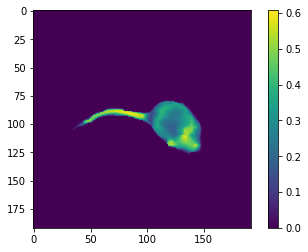

In [11]:
plt.imshow(all_data[0])
plt.colorbar()

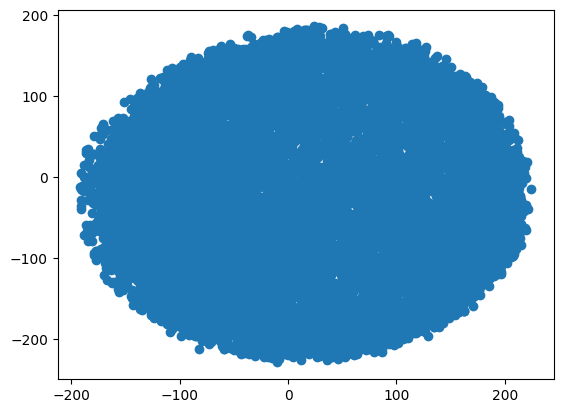

In [10]:
cc = np.vstack(crop_origins)[::100,:]
plt.scatter(cc[:,0],cc[:,1])

In [86]:
XY_OFFSET

array([263.6023957 , 353.54050039])